In [1]:
import numpy as np
import scipy
from scipy.signal import lfilter, freqz
import matplotlib.pyplot as plt

In [2]:
h = np.array([
    
    -1, 0, 3, 0, -8, 0, 21, 0, -45, 0, 91, 0, -191, 0, 643, 1024,
    643, 0, -191, 0, 91, 0, -45, 0, 21, 0, -8, 0, 3, 0, -1

], dtype=float)/2050
H_COEFFS = h

e0 = h[0::2]
e1 = h[1::2]

In [5]:
def plot_filter(h, ax1, ax2):

    N = 4096
    h0 = h
    h1 = h * ((-1)**np.arange(len(h)))


    h0_2jw = np.zeros(len(h0)*2, dtype=complex)
    h0_2jw[0::2] = h0
    h1_2jw = np.zeros(len(h1)*2, dtype=complex)
    h1_2jw[0::2] = h1
    h0_4jw = np.zeros(len(h0)*4, dtype=complex)
    h0_4jw[0::4] = h0
    h1_4jw = np.zeros(len(h1)*4, dtype=complex)
    h1_4jw[0::4] = h1

    fft_h0 = np.fft.fft(h0, N)
    fft_h1 = np.fft.fft(h1, N)
    fft_h0_2jw = np.fft.fft(h0_2jw, N)
    fft_h1_2jw = np.fft.fft(h1_2jw, N)
    fft_h0_4jw = np.fft.fft(h0_4jw, N)
    fft_h1_4jw = np.fft.fft(h1_4jw, N)
    


    fft_mag_h0 = np.abs(fft_h0)
    fft_mag_h1 = np.abs(fft_h1)
    fft_mag_h0_2jw = np.abs(fft_h0_2jw)
    fft_mag_h1_2jw = np.abs(fft_h1_2jw)
    fft_mag_h0_4jw = np.abs(fft_h0_4jw)     
    fft_mag_h1_4jw = np.abs(fft_h1_4jw)

    fft_phase_h0 = np.unwrap(np.angle(fft_h0)) 
    fft_phase_h1 = np.unwrap(np.angle(fft_h1))  
    fft_phase_h0_2jw = np.unwrap(np.angle(fft_h0_2jw))
    fft_phase_h1_2jw = np.unwrap(np.angle(fft_h1_2jw))
    fft_phase_h0_4jw = np.unwrap(np.angle(fft_h0_4jw))
    fft_phase_h1_4jw = np.unwrap(np.angle(fft_h1_4jw))

    H_mag = fft_mag_h0
    H_phase = fft_phase_h0

    H3_mag = fft_mag_h1
    H3_phase = fft_phase_h1

    H2_mag = fft_mag_h0*fft_mag_h0_2jw
    H2_phase = fft_phase_h0 + fft_phase_h1_2jw
    
    H1_mag = fft_mag_h0*fft_mag_h0_2jw*fft_mag_h1_4jw
    H1_phase = fft_phase_h0 + fft_phase_h1_2jw + fft_phase_h1_4jw

    H0_mag = fft_mag_h0*fft_mag_h0_2jw*fft_mag_h0_4jw
    H0_phase = fft_phase_h0 + fft_phase_h0_2jw + fft_phase_h0_4jw


    w = np.linspace(0, 2*np.pi, N)
    ax1.plot(w/np.pi, 20*np.log10((H_mag)/np.max(H_mag)), label='H')
    ax1.plot(w/np.pi, 20*np.log10((H0_mag)/np.max(H0_mag)), label='H0')
    ax1.plot(w/np.pi, 20*np.log10((H1_mag)/np.max(H1_mag)), label='H1')
    ax1.plot(w/np.pi, 20*np.log10((H2_mag)/np.max(H2_mag)), label='H2')
    ax1.plot(w/np.pi, 20*np.log10((H3_mag)/np.max(H3_mag)), label='H3')
    ax1.set_ylabel('Magnitude (dB)')
    ax1.set_xlabel('Normalized Frequency (×π rad/sample)')
    ax1.legend()

    ax1.set_title('Filter Magnitude Response')

    ax2.plot(w/np.pi, H_phase, label='H')
    ax2.plot(w/np.pi, H0_phase, label='H0')
    ax2.plot(w/np.pi, H1_phase, label='H1')
    ax2.plot(w/np.pi, H2_phase, label='H2')
    ax2.plot(w/np.pi, H3_phase, label='H3')
    ax2.set_ylabel('Phase (radians)')
    ax2.set_xlabel('Normalized Frequency (×π rad/sample)')
    ax2.legend()
    ax2.set_title('Filter Phase Response')


    plt.show()

In [6]:
def plot_all_transfer_functions(option=1):
    """
    Plots the magnitude and phase responses of:
    1. Equivalent Analysis Filters (H0, H1, H2, H3)
    2. Equivalent Synthesis Filters (G0, G1, G2, G3)
    3. Overall System Transfer Function T(z)
    """
    print("\n--- Generating Analysis, Synthesis, and Overall Transfer Function Plots ---")
    
    N_FFT = 4096
    h = H_COEFFS
    # Analysis HPF H(-z) = H(e^j(w-pi)) -> h[n]*(-1)^n
    h_hpf = h * ((-1)**np.arange(len(h)))
    
    # Synthesis Filters (Option 1)
    f0 = h
    if option == 1:
        f1 = -1 * h_hpf # F1(z) = -H(-z)
    else:
        f1 = h_hpf   # F1(z) = H(-z)

    # --- Upsampled Impulse Responses (for equivalent filter construction) ---
    def upsample_filter(coeffs, factor):
        upsampled = np.zeros(len(coeffs) * factor)
        upsampled[::factor] = coeffs
        return upsampled

    h_2jw = upsample_filter(h, 2)
    h_hpf_2jw = upsample_filter(h_hpf, 2)
    h_4jw = upsample_filter(h, 4)
    h_hpf_4jw = upsample_filter(h_hpf, 4)
    
    # Synthesis Upsampled
    f0_2jw = upsample_filter(f0, 2)
    f0_4jw = upsample_filter(f0, 4)
    f1_2jw = upsample_filter(f1, 2)
    f1_4jw = upsample_filter(f1, 4)

    # --- FFTs ---
    fft_h = np.fft.fft(h, N_FFT)
    fft_h_hpf = np.fft.fft(h_hpf, N_FFT)
    fft_h_2jw = np.fft.fft(h_2jw, N_FFT)
    fft_h_hpf_2jw = np.fft.fft(h_hpf_2jw, N_FFT)
    fft_h_4jw = np.fft.fft(h_4jw, N_FFT)
    fft_h_hpf_4jw = np.fft.fft(h_hpf_4jw, N_FFT)
    
    fft_f0 = np.fft.fft(f0, N_FFT)
    fft_f1 = np.fft.fft(f1, N_FFT)
    fft_f0_2jw = np.fft.fft(f0_2jw, N_FFT)
    fft_f0_4jw = np.fft.fft(f0_4jw, N_FFT)
    fft_f1_2jw = np.fft.fft(f1_2jw, N_FFT)
    fft_f1_4jw = np.fft.fft(f1_4jw, N_FFT)

    # --- 1. Analysis Equivalent Filters (Hk) ---
    # V3 (H3): H(-z)
    H3_fft = fft_h_hpf
    # V2 (H2): H(z) * H(-z^2)
    H2_fft = fft_h * fft_h_hpf_2jw
    # V1 (H1): H(z) * H(z^2) * H(-z^4)
    H1_fft = fft_h * fft_h_2jw * fft_h_hpf_4jw
    # V0 (H0): H(z) * H(z^2) * H(z^4)
    H0_fft = fft_h * fft_h_2jw * fft_h_4jw

    # --- 2. Synthesis Equivalent Filters (Gk) ---
    # The synthesis bank is the reverse structure.
    # G3 (Channel 3): Enters at Stage 1. Filter F1(z).
    G3_fft = fft_f1
    
    # G2 (Channel 2): Enters at Stage 2. 
    # Path: Upsample(2) -> F1(z) -> Join with V0/V1 branch -> Upsample(2) -> F0(z)
    # Effect: F1(z^2) * F0(z)
    G2_fft = fft_f1_2jw * fft_f0
    
    # G1 (Channel 1): Enters at Stage 3.
    # Path: Upsample(2) -> F1(z) -> Upsample(2) -> F0(z) -> Upsample(2) -> F0(z)
    # Effect: F1(z^4) * F0(z^2) * F0(z)
    G1_fft = fft_f1_4jw * fft_f0_2jw * fft_f0
    
    # G0 (Channel 0): Enters at Stage 3.
    # Path: Upsample(2) -> F0(z) -> Upsample(2) -> F0(z) -> Upsample(2) -> F0(z)
    # Effect: F0(z^4) * F0(z^2) * F0(z)
    G0_fft = fft_f0_4jw * fft_f0_2jw * fft_f0

    # --- 3. Overall Transfer Function T(z) ---
    # Sum of Hk * Gk
    T_overall_fft = (H0_fft * G0_fft) + (H1_fft * G1_fft) + (H2_fft * G2_fft) + (H3_fft * G3_fft)

    # --- Plotting Helpers ---
    def calc_mag_db(fft_data, normalize=True):
        mag = np.abs(fft_data)
        if normalize:
            return 20 * np.log10(mag / np.max(mag) + 1e-12)
        else:
            return 20 * np.log10(mag + 1e-12)

    def calc_phase(fft_data):
        return np.unwrap(np.angle(fft_data))

    w = np.linspace(0, 2, N_FFT)

    # --- Plot 1: Analysis Filters ---
    fig1, (ax1a, ax1b) = plt.subplots(2, 1, figsize=(10, 8))
    ax1a.plot(w, calc_mag_db(H0_fft), label='H0 (V0)')
    ax1a.plot(w, calc_mag_db(H1_fft), label='H1 (V1)')
    ax1a.plot(w, calc_mag_db(H2_fft), label='H2 (V2)')
    ax1a.plot(w, calc_mag_db(H3_fft), label='H3 (V3)')
    ax1a.set_title('Analysis Filters Magnitude (dB)')
    # ax1a.set_xlim([0, 1])
    # ax1a.set_ylim([-60, 5])
    ax1a.grid(True, linestyle='--', alpha=0.5)
    ax1a.legend()
    
    ax1b.plot(w, calc_phase(H0_fft), label='H0')
    ax1b.plot(w, calc_phase(H1_fft), label='H1')
    ax1b.plot(w, calc_phase(H2_fft), label='H2')
    ax1b.plot(w, calc_phase(H3_fft), label='H3')
    ax1b.set_title('Analysis Filters Phase')
    ax1b.set_xlabel(r'Normalized Frequency ($\times \pi$ rad/sample)')
    # ax1b.set_xlim([0, 1])
    ax1b.grid(True, linestyle='--', alpha=0.5)
    ax1b.legend()
    
    # --- Plot 2: Synthesis Filters ---
    fig2, (ax2a, ax2b) = plt.subplots(2, 1, figsize=(10, 8))
    ax2a.plot(w, calc_mag_db(G0_fft), label='G0 (V0)')
    ax2a.plot(w, calc_mag_db(G1_fft), label='G1 (V1)')
    ax2a.plot(w, calc_mag_db(G2_fft), label='G2 (V2)')
    ax2a.plot(w, calc_mag_db(G3_fft), label='G3 (V3)')
    ax2a.set_title('Synthesis Filters Magnitude (dB)')
    # ax2a.set_xlim([0, 1])
    # ax2a.set_ylim([-60, 5])
    ax2a.grid(True, linestyle='--', alpha=0.5)
    ax2a.legend()
    
    ax2b.plot(w, calc_phase(G0_fft), label='G0')
    ax2b.plot(w, calc_phase(G1_fft), label='G1')
    ax2b.plot(w, calc_phase(G2_fft), label='G2')
    ax2b.plot(w, calc_phase(G3_fft), label='G3')
    ax2b.set_title('Synthesis Filters Phase')
    ax2b.set_xlabel(r'Normalized Frequency ($\times \pi$ rad/sample)')
    # ax2b.set_xlim([0, 1])
    ax2b.grid(True, linestyle='--', alpha=0.5)
    ax2b.legend()

    # --- Plot 3: Overall System Transfer Function ---
    fig3, (ax3a, ax3b) = plt.subplots(2, 1, figsize=(10, 8))
    # Note: T(z) should ideally be flat magnitude (Linear Phase / Pure Delay)
    ax3a.plot(w, calc_mag_db(T_overall_fft, normalize=False), 'k', label='|T(z)|')
    ax3a.set_title('Overall System Magnitude Response |T(z)|')
    ax3a.set_ylabel('Magnitude (dB)')
    ax3a.set_xlabel(r'Normalized Frequency ($\times \pi$ rad/sample)')
    # ax3a.set_xlim([0, 1])
    ax3a.grid(True, linestyle='--', alpha=0.5)
    
    # Analyze flatness (Ripple)
    mag_linear = np.abs(T_overall_fft)
    ripple_std = np.std(mag_linear)
    ax3a.text(0.5, np.mean(calc_mag_db(T_overall_fft, False)), f"Ripple Std Dev: {ripple_std:.4e}")

    ax3b.plot(w, calc_phase(T_overall_fft), 'r', label='Angle(T(z))')
    ax3b.set_title('Overall System Phase Response')
    ax3b.set_ylabel('Phase (radians)')
    ax3b.set_xlabel(r'Normalized Frequency ($\times \pi$ rad/sample)')
    # ax3b.set_xlim([0, 1])
    ax3b.grid(True, linestyle='--', alpha=0.5)
    
    # Check linearity
    # Linear phase implies phase = -k * w
    # We can plot the group delay of T(z) as well, or just show linear slope
    
    plt.tight_layout()
    plt.show()


--- Generating Analysis, Synthesis, and Overall Transfer Function Plots ---


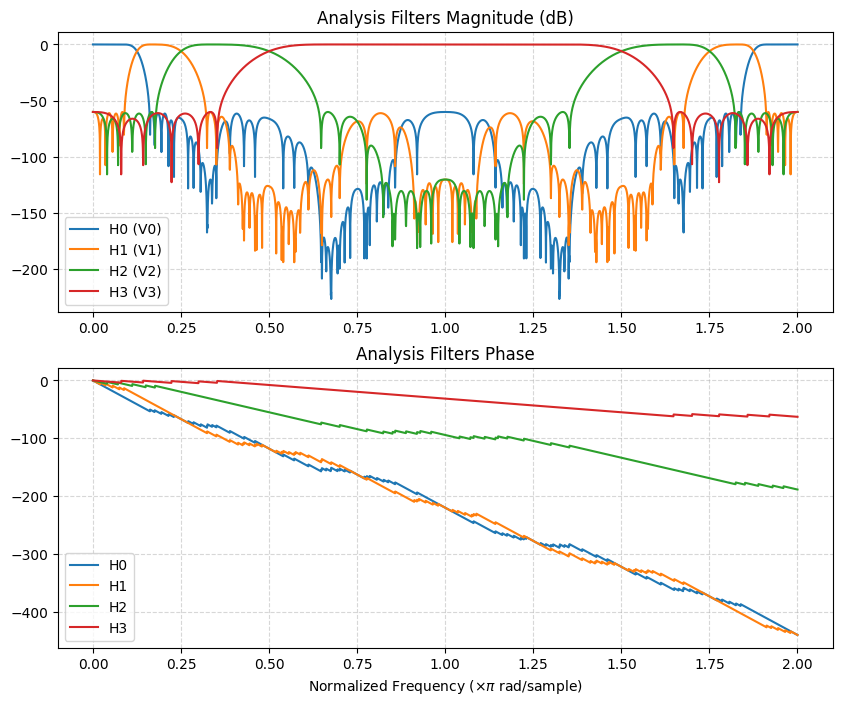

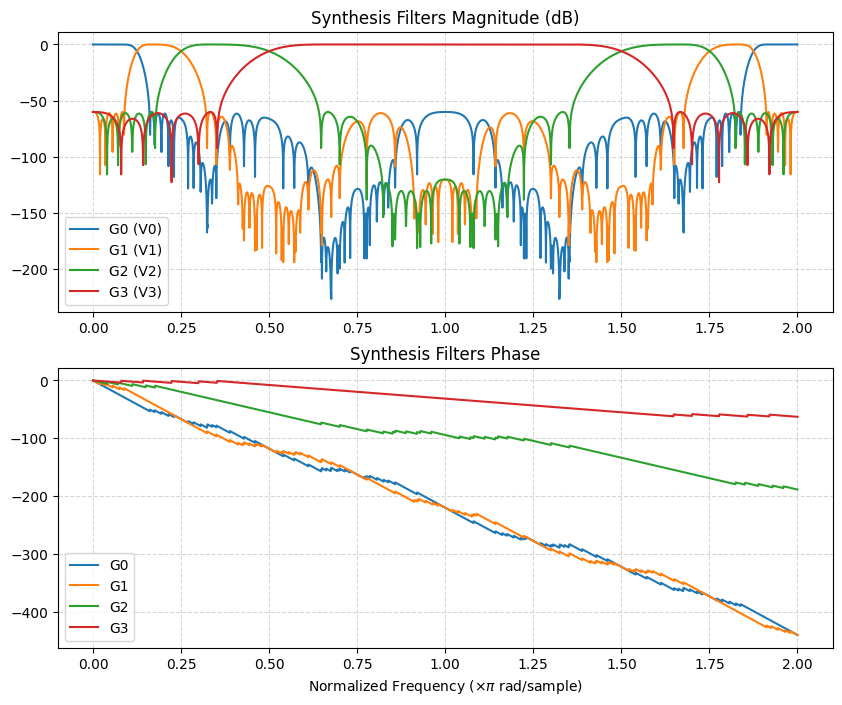

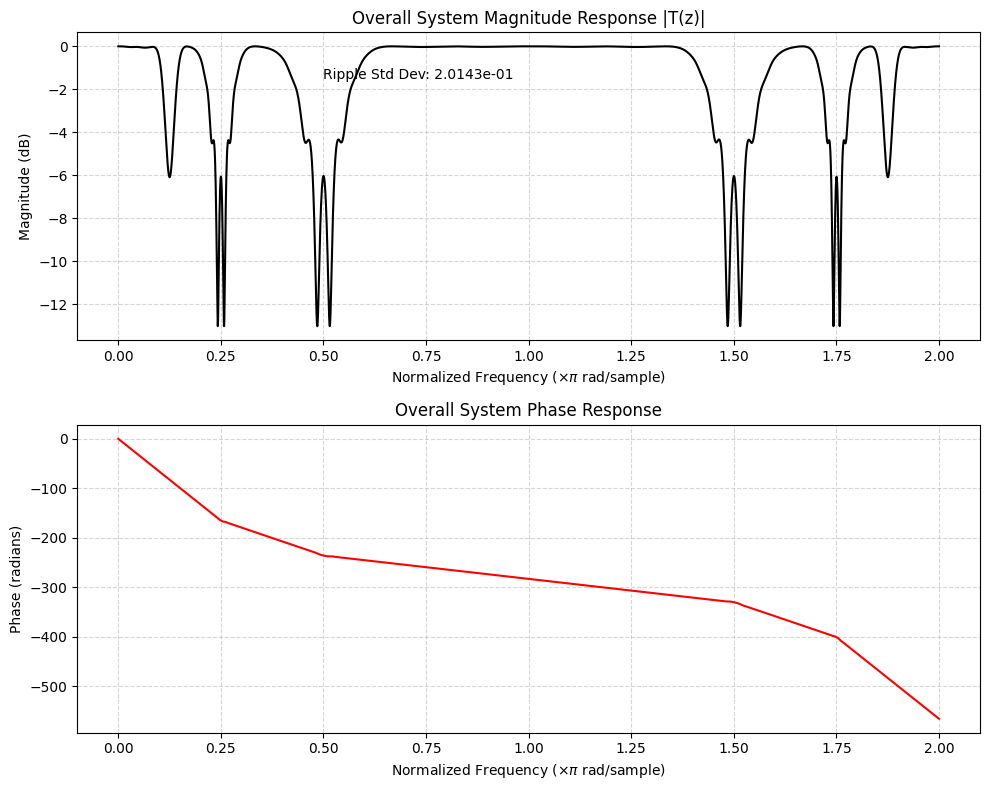

In [7]:
plot_all_transfer_functions(option=2)

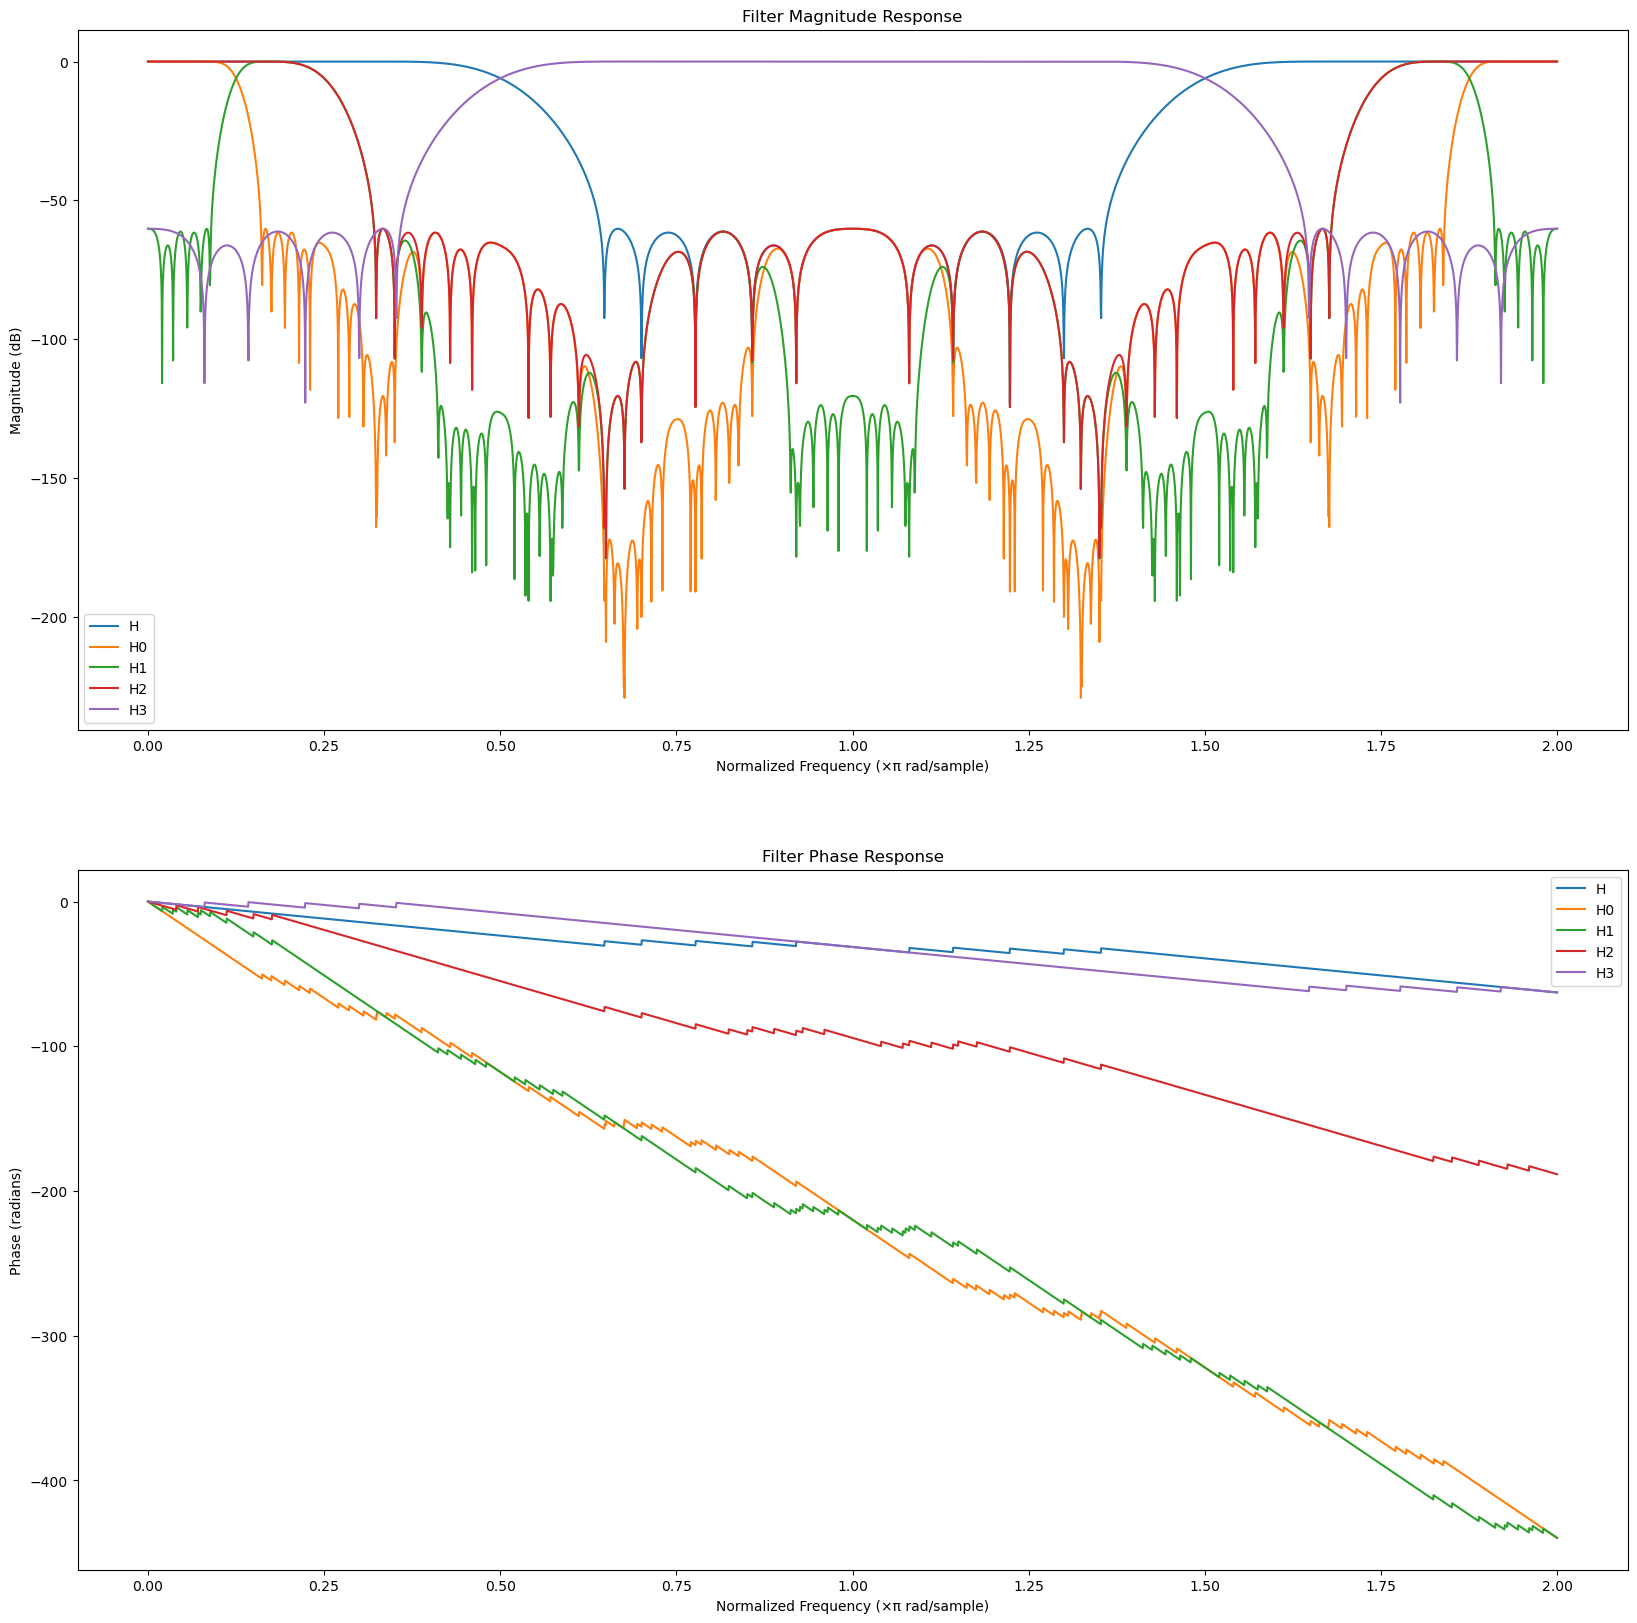

In [224]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
plot_filter(h, ax1, ax2)

In [8]:
def type1_input_gen(N=1024):
    # 16-bit range [-2^15, 2^15-1]
    real = np.random.randint(-2**15, 2**15, size=N)
    imag = np.random.randint(-2**15, 2**15, size=N)
    return real.astype(float) + 1j * imag.astype(float)


In [9]:
def type2_input_gen(N=1024):
    n = np.arange(N)
    xr = (1344 * np.cos(0.06*np.pi*n) +
          864  * np.cos(0.18*np.pi*n) +
          8543 * np.cos(0.38*np.pi*n) -
          43   * np.cos(0.8*np.pi*n))
    xi = (1344 * np.sin(0.06*np.pi*n) +
          864  * np.sin(0.18*np.pi*n) +
          8543 * np.sin(0.38*np.pi*n) -
          43   * np.sin(0.8*np.pi*n))
    return xr + 1j*xi


In [227]:
def add_awgn(x, snr_db):
    sig_power = np.mean(np.abs(x)**2)
    snr_lin = 10**(snr_db/10)
    noise_power = sig_power / snr_lin
    noise = np.sqrt(noise_power/2) * (np.random.randn(*x.shape) + 1j*np.random.randn(*x.shape))
    return x + noise


In [228]:
def mse_per_frame(x, x_hat):
    # trim to common length in case of filter delay
    L = min(len(x), len(x_hat))
    x = x[:L]
    x_hat = x_hat[:L]
    num = np.abs(x - x_hat)**2
    denom = np.abs(x)**2 + 1e-12
    return np.sqrt(np.mean(num / denom))


In [229]:
def analysis_filterblock(x, e0, e1):
    M = 2
    # h_e0 = h[0::M]
    # h_e1 = h[1::M]
    
    x_top = x[0::M]
    x_bot = x[1::M]
    valid_len = min(len(x_top), len(x_bot))
    y0 = lfilter(e0, 1, x_top.astype(complex))[:valid_len]
    y1 = lfilter(e1, 1, x_bot.astype(complex))[:valid_len]
    y1 = np.concatenate(([0], y1[:-1]))
    v0 = y0 + y1
    v1 = y0 - y1

    return v0, v1



In [230]:
def synthesis_filterblock(v0, v1, e0, e1, option=1):
    valid_len = min(len(v0), len(v1))
    # f0 = h0 = h, f1 = -h1 = -h(-z)
    # h = e0(z^2) + z^-1 e1(z^2)
    # h(-z) = e0(z^2) - z^-1 e1(z^2)
    # f = h = e0(z^2) + z^-1 e1(z^2)


    if option == 1:
        w0 = v0 - v1
        w1 = v0 + v1
    else:
        w0 = v0 + v1
        w1 = v0 - v1

    X_e_hat = lfilter(e0, 1.0, w0)[:valid_len]
    X_o_hat = lfilter(e1, 1.0, w1)[:valid_len]

    
    x = np.zeros(2*len(v0), dtype=complex)
    x[0::2] = X_e_hat
    x[1::2] = X_o_hat
    return x

In [231]:
def analysis_filterbank(x, e0, e1):

    d0_h0, d0_h1 =analysis_filterblock(x, e0, e1)
    d1_h0, d1_h1 =analysis_filterblock(d0_h0, e0, e1)
    d2_h0, d2_h1 =analysis_filterblock(d1_h0, e0, e1)

    V0 = d2_h0
    V1 = d2_h1
    V2 = d1_h1
    V3 = d0_h1
    
    return V0, V1, V2, V3


In [232]:
def synthesis_filterbank(V0, V1, V2, V3, e0, e1, option=1):
    
    u0 = synthesis_filterblock(V0, V1, e0, e1, option)
    u1 = synthesis_filterblock(u0, V2, e0, e1, option)
    u2 = synthesis_filterblock(u1, V3, e0, e1, option)

    x_hat = u2

    return x_hat


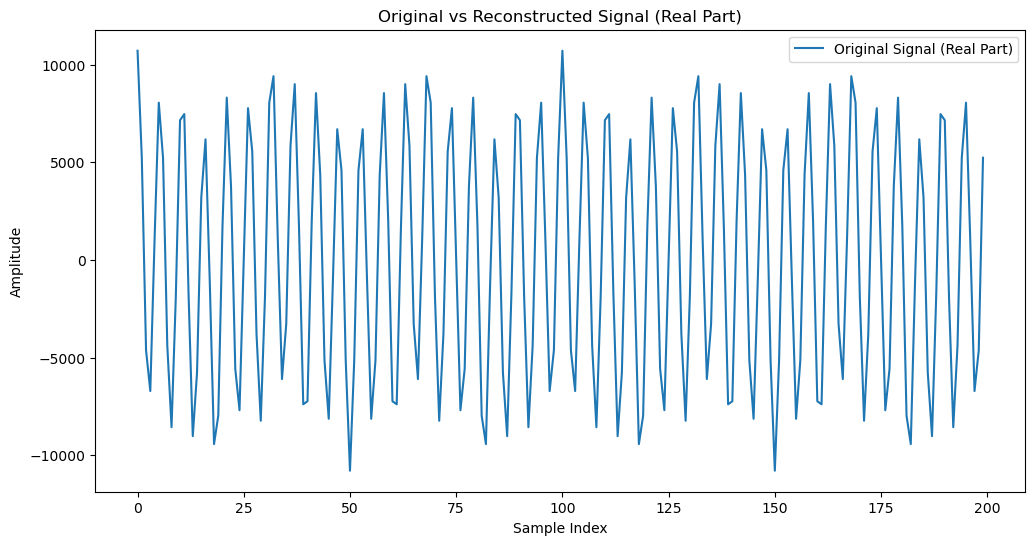

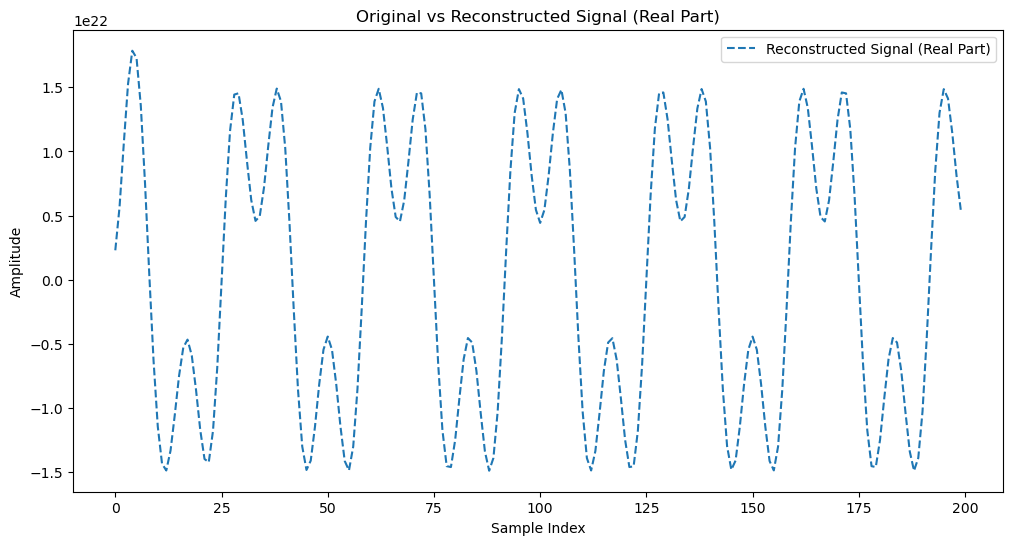

In [256]:
x = type2_input_gen()
V0, V1, V2, V3 = analysis_filterbank(x, e0, e1)
x_hat = synthesis_filterbank(V0, V1, V2, V3, e0, e1, option=1)
TOTAL_DELAY = 210
X_ref = x[:-TOTAL_DELAY]

# 2. Truncate the output X_hat to ignore the initial transient (delay)
X_est = x_hat[TOTAL_DELAY:]
plt.figure(figsize=(12, 6))
plt.plot(np.real(X_ref[0:200]), label='Original Signal (Real Part)')

plt.title('Original vs Reconstructed Signal (Real Part)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
# plt.plot(np.real(x), label='Original Signal (Real Part)')
plt.plot(np.real(X_est[0:200]), linestyle='--', label='Reconstructed Signal (Real Part)')
plt.title('Original vs Reconstructed Signal (Real Part)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

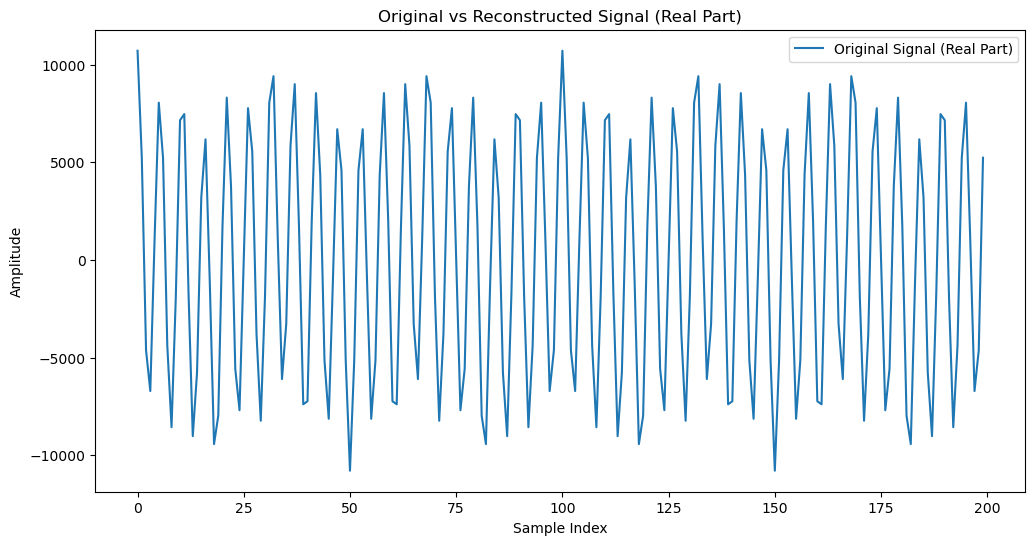

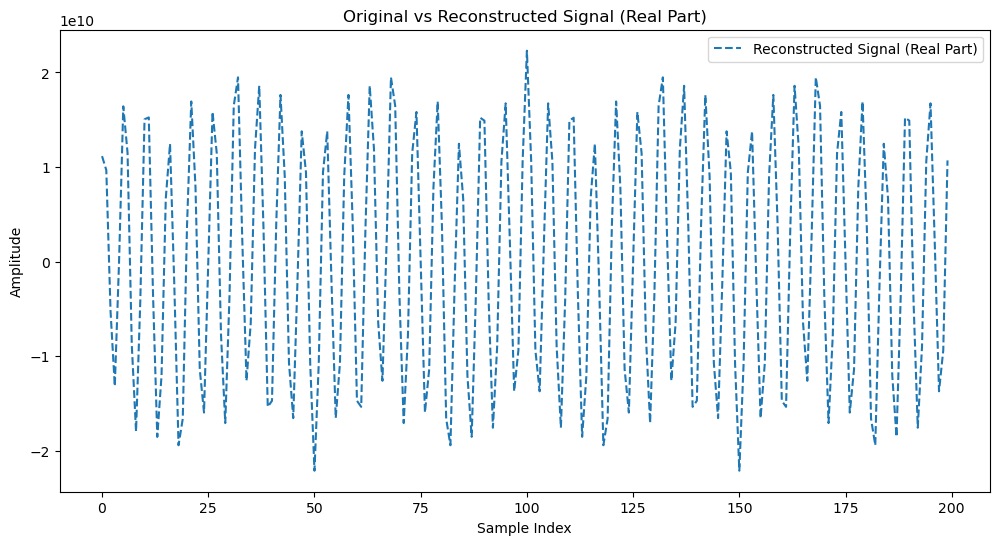

In [253]:
x = type2_input_gen()
V0, V1= analysis_filterblock(x, e0, e1)
x_hat = synthesis_filterblock(V0, V1, e0, e1, option=1)
TOTAL_DELAY = 30
X_ref = x[:-TOTAL_DELAY]

# 2. Truncate the output X_hat to ignore the initial transient (delay)
X_est = x_hat[TOTAL_DELAY:]
plt.figure(figsize=(12, 6))
plt.plot(np.real(X_ref[0:200]), label='Original Signal (Real Part)')

plt.title('Original vs Reconstructed Signal (Real Part)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
# plt.plot(np.real(x), label='Original Signal (Real Part)')
plt.plot(np.real(X_est[0:200]), linestyle='--', label='Reconstructed Signal (Real Part)')
plt.title('Original vs Reconstructed Signal (Real Part)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
def simulate_mse(h, signal_type="type1", option=1, n_frames=1000):
    TOTAL_DELAY = 210
    mses = []
    e0 = h[0::2]
    e1 = h[1::2]
    for _ in range(n_frames):
        if signal_type == "type1":
            x = type1_input_gen()
        else:
            x = type2_input_gen()

        V0, V1, V2, V3 = analysis_filterbank(x, e0, e1)
        x_hat = synthesis_filterbank(V0, V1, V2, V3, e0, e1, option=option)
        X_ref = x[:-TOTAL_DELAY]
    
        # 2. Truncate the output X_hat to ignore the initial transient (delay)
        X_est = x_hat[TOTAL_DELAY:]
    
        # 3. Ensure lengths match exactly
        min_len = min(len(X_ref), len(X_est))
        X_ref = X_ref[:min_len]
        X_est = X_est[:min_len]
        mses.append(mse_per_frame(X_ref, X_est))
    # print(mses)
    return np.mean(mses)


In [236]:
avg_mse_type_1_opt_1 = simulate_mse(h, signal_type="type1", option=1, n_frames=1000)
avg_mse_type_2_opt_1 = simulate_mse(h, signal_type="type2", option=1, n_frames=1000)
avg_mse_type_1_opt_2 = simulate_mse(h, signal_type="type1", option=2, n_frames=1000)
avg_mse_type_2_opt_2 = simulate_mse(h, signal_type="type2", option=2, n_frames=1000)

print("Average MSE (Type 1, Option 1):", avg_mse_type_1_opt_1)
print("Average MSE (Type 2, Option 1):", avg_mse_type_2_opt_1)
print("Average MSE (Type 1, Option 2):", avg_mse_type_1_opt_2)
print("Average MSE (Type 2, Option 2):", avg_mse_type_2_opt_2)

Average MSE (Type 1, Option 1): 1.3110951192680773
Average MSE (Type 2, Option 1): 1.1015724940443214
Average MSE (Type 1, Option 2): 1.3078416310606404
Average MSE (Type 2, Option 2): 0.954195341999423


In [237]:

V0,V1,V2,V3 = analysis_filterbank(x, e0, e1)
x_hat = synthesis_filterbank(V0, V1, V2, V3, e0, e1, option=1)

In [238]:
d = scipy.signal.unit_impulse(1024)
d0_h0, d0_h1 = analysis_filterblock(d, e0, e1)
d_hat_opt1 = synthesis_filterblock(d0_h0, d0_h1, e0, e1, option=1)
D_hat_opt1 = np.fft.fft(d_hat_opt1)

In [239]:
d = scipy.signal.unit_impulse(1024)
d0_h0, d0_h1 = analysis_filterblock(d, e0, e1)
d_hat_opt2 = synthesis_filterblock(d0_h0, d0_h1, e0, e1, option=2)
D_hat_opt2 = np.fft.fft(d_hat_opt2)

/opt/miniconda3/envs/env/lib/python3.14/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/env/lib/python3.14/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


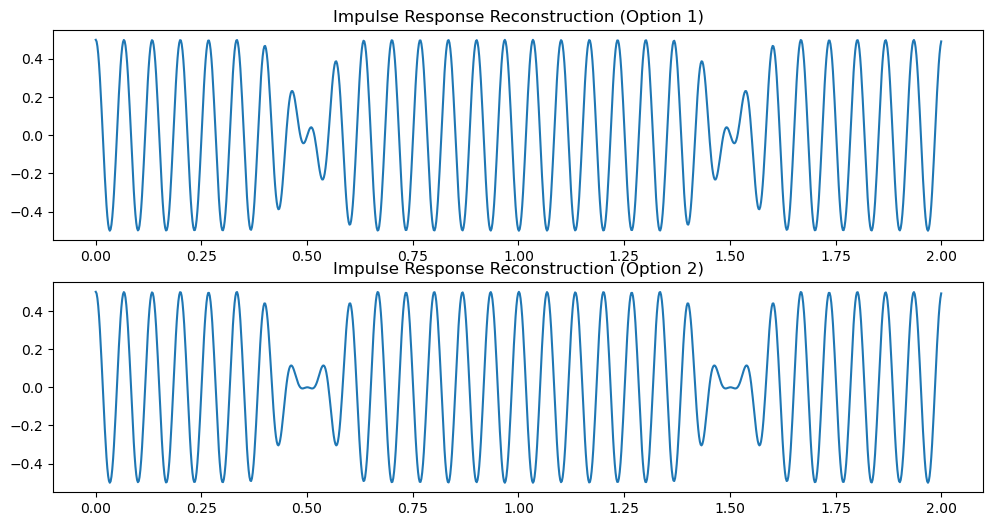

In [240]:
plt.figure(figsize=(12, 6))
w = np.linspace(0, 2*np.pi, len(D_hat_opt1))
plt.subplot(2, 1, 1)
plt.title('Impulse Response Reconstruction (Option 1)')
plt.plot(w/np.pi, D_hat_opt1)
plt.subplot(2, 1, 2)
plt.title('Impulse Response Reconstruction (Option 2)')
plt.plot(w/np.pi, D_hat_opt2)
plt.show()


In [241]:
def generate_test_input():
    N = 20000
    duration = 1.0
    f = N/duration
    fs = f*2
    t = np.linspace(0, duration, int(fs))
    impulse = np.zeros(31)
    impulse[0] = 100
    chirp_sig = scipy.signal.chirp(t, f0 = 0, t1 = 1, f1 = f, method ='linear')
    return chirp_sig

In [242]:
chirp_sig = generate_test_input()

(array([[7.11681900e-06, 1.21053166e-14, 6.22456723e-13, ...,
         1.81823418e-21, 7.61314211e-22, 8.46162293e-23],
        [3.44994458e-05, 2.48256084e-11, 1.39085279e-12, ...,
         3.65388601e-21, 1.52679455e-21, 1.76367928e-22],
        [1.41364907e-04, 1.15966576e-10, 1.84889287e-12, ...,
         3.71905894e-21, 1.54018171e-21, 1.98418305e-22],
        ...,
        [7.55945786e-23, 2.17496766e-22, 8.09960403e-23, ...,
         1.31222326e-12, 4.05715357e-11, 5.82910195e-08],
        [7.64005664e-23, 1.34013442e-22, 7.95901722e-23, ...,
         1.25126500e-12, 3.59019818e-11, 2.58437782e-08],
        [3.83351167e-23, 5.30929639e-23, 3.95597224e-23, ...,
         6.15756106e-13, 1.72275705e-11, 9.55875274e-09]], shape=(513, 44)),
 array([    0.    ,    39.0625,    78.125 ,   117.1875,   156.25  ,
          195.3125,   234.375 ,   273.4375,   312.5   ,   351.5625,
          390.625 ,   429.6875,   468.75  ,   507.8125,   546.875 ,
          585.9375,   625.    ,   664.0625, 

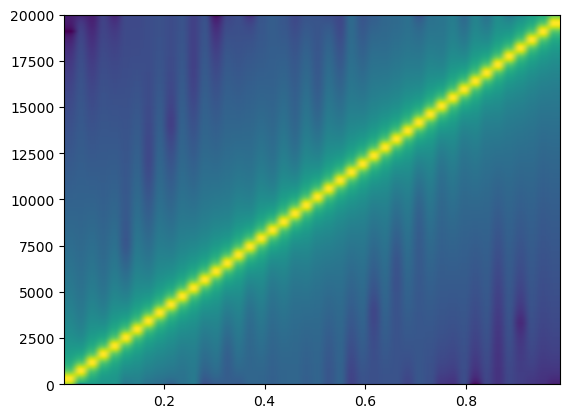

In [243]:
plt.specgram(chirp_sig, NFFT=1024, Fs=40000)

(array([[4.81641392e+00, 2.44662297e-09, 4.63978707e-09, ...,
         4.76240465e+00, 4.80540038e+01, 1.69588241e+04],
        [4.81645529e+00, 2.45245577e-09, 4.69501746e-09, ...,
         4.82775648e+00, 5.01839298e+01, 2.66278459e+04],
        [4.81657943e+00, 2.46998650e-09, 4.86081890e-09, ...,
         5.02858158e+00, 5.70849524e+01, 7.20681300e+04],
        ...,
        [4.81678644e+00, 2.49920164e-09, 5.13715663e-09, ...,
         5.37977094e+00, 7.04885805e+01, 2.41983153e+05],
        [4.81657943e+00, 2.46998646e-09, 4.86081894e-09, ...,
         5.02858158e+00, 5.70849524e+01, 7.20681300e+04],
        [4.81645529e+00, 2.45245572e-09, 4.69501743e-09, ...,
         4.82775648e+00, 5.01839298e+01, 2.66278459e+04]], shape=(1024, 44)),
 array([-20000.    , -19960.9375, -19921.875 , ...,  19882.8125,
         19921.875 ,  19960.9375], shape=(1024,)),
 array([0.0128, 0.0352, 0.0576, 0.08  , 0.1024, 0.1248, 0.1472, 0.1696,
        0.192 , 0.2144, 0.2368, 0.2592, 0.2816, 0.304 , 0.3

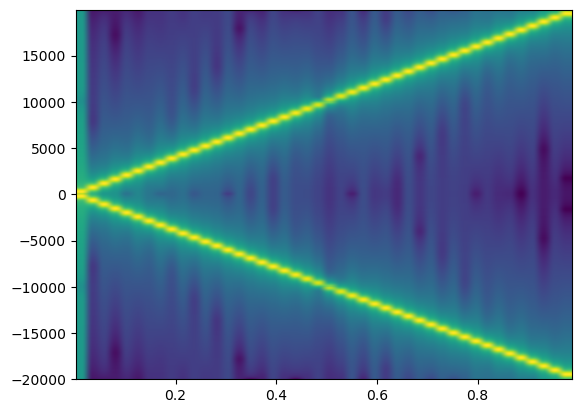

In [244]:
chirp_sig = generate_test_input()
h = np.array([
    
    -1, 0, 3, 0, -8, 0, 21, 0, -45, 0, 91, 0, -191, 0, 643, 1024,
    643, 0, -191, 0, 91, 0, -45, 0, 21, 0, -8, 0, 3, 0, -1

], dtype=float)
e0 = h[0::2]
e1 = h[1::2]
d0_h0, d0_h1 = analysis_filterblock(chirp_sig, e0, e1)
x_hat = synthesis_filterblock(d0_h0, d0_h1, e0, e1, option=1)
plt.specgram(x_hat, NFFT=1024, Fs=40000)

(array([[4.23039730e+01, 3.34774777e-03, 1.09668328e-05, ...,
         4.76240955e+00, 4.80541691e+01, 1.69588883e+04],
        [4.09251805e+02, 3.71452052e-03, 1.16093187e-05, ...,
         4.82776145e+00, 5.01841021e+01, 2.66279464e+04],
        [2.04521085e+03, 5.02568440e-03, 1.36352157e-05, ...,
         5.02858676e+00, 5.70851475e+01, 7.20684009e+04],
        ...,
        [5.93059294e+03, 8.11582770e-03, 1.73625570e-05, ...,
         5.37977649e+00, 7.04888195e+01, 2.41984060e+05],
        [2.04521085e+03, 5.02568440e-03, 1.36352158e-05, ...,
         5.02858676e+00, 5.70851475e+01, 7.20684009e+04],
        [4.09251805e+02, 3.71452053e-03, 1.16093187e-05, ...,
         4.82776145e+00, 5.01841021e+01, 2.66279464e+04]], shape=(1024, 44)),
 array([-20000.    , -19960.9375, -19921.875 , ...,  19882.8125,
         19921.875 ,  19960.9375], shape=(1024,)),
 array([0.0128, 0.0352, 0.0576, 0.08  , 0.1024, 0.1248, 0.1472, 0.1696,
        0.192 , 0.2144, 0.2368, 0.2592, 0.2816, 0.304 , 0.3

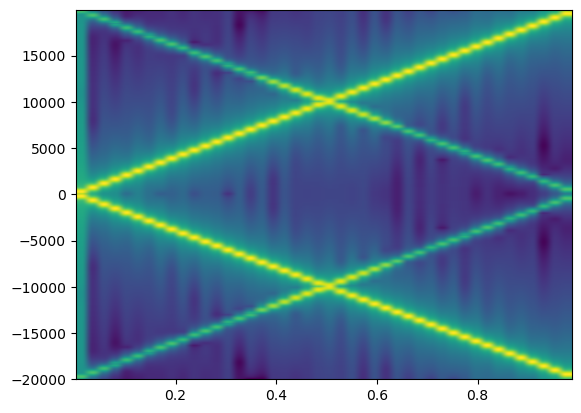

In [245]:
chirp_sig = generate_test_input()
h = np.array([
    
    -1, 0, 3, 0, -8, 0, 21, 0, -45, 0, 91, 0, -191, 0, 643, 1024,
    643, 0, -191, 0, 91, 0, -45, 0, 21, 0, -8, 0, 3, 0, -1

], dtype=float)
e0 = h[0::2]
e1 = h[1::2]
d0_h0, d0_h1 = analysis_filterblock(chirp_sig, e0, e1)
x_hat = synthesis_filterblock(d0_h0, d0_h1, e0, e1, option=2)
plt.specgram(x_hat, NFFT=1024, Fs=40000)

In [246]:
class LFSR:
    """
    Linear Feedback Shift Register for PN sequence generation.
    Implements a 26-bit LFSR.
    State bits: [b25, b24, ... b0] where b25 is index 0, b0 is index 25.
    """
    def __init__(self, key, taps):
        # key is the initial state (must be 26 bits)
        if not isinstance(key, int) or not (0 <= key < 2**26):
            raise ValueError("Key must be an integer between 0 and 2^26 - 1")
            
        # Convert key to bit array. 
        # binary_repr(width=26) returns string 'MSB...LSB'. 
        # So index 0 corresponds to b25, index 25 corresponds to b0.
        self.state = np.array([int(b) for b in np.binary_repr(key, width=26)], dtype=int)
        
        # Taps provided as bit positions [25, 3, 0].
        # We need to map bit position 'k' to array index '25-k'.
        # b25 -> index 0, b0 -> index 25.
        self.tap_indices = [25 - t for t in taps]

    def generate_bit(self):
        # Calculate feedback bit (XOR sum of taps)
        # PN sequence equation is typically the feedback equation.
        # Fig 5 shows Sum -> PN Bit AND Sum -> Input (b0)
        feedback = 0
        for idx in self.tap_indices:
            feedback ^= self.state[idx]
        
        # Shift left: b_n becomes b_{n+1}. b25 (index 0) is shifted out.
        # Shift array elements to the left (index i becomes i-1)
        self.state = np.roll(self.state, -1)
        
        # Insert feedback at b0 (index 25)
        self.state[25] = feedback
        
        return feedback



In [247]:

def generate_pn_sequences(channel_lengths, frame_num, GROUP_ID=0x2B):
    """
    Generates Real (PN1) and Imaginary (PN2) scrambling sequences for all 4 channels.
    Returns: Two lists of arrays (pn_i_k_list, pn_q_k_list)
    """
    # Taps definition (from Project PDF Part 3.2)
    # PN1: b25 XOR b3 XOR b0
    taps1 = [25, 3, 0]
    # PN2: b25 XOR b3 XOR b2 XOR b1 XOR b0
    taps2 = [25, 3, 2, 1, 0]
    
    # Key Generation Logic (Part 3.3.i-iv)
    # k=0: (Frame << 10) + GroupID
    # k=1: (Frame << 11) + 3*GroupID
    # k=2: (Frame << 12) + 5*GroupID
    # k=3: (Frame << 13) + 7*GroupID
    key_params = [
        (10, 1), 
        (11, 3), 
        (12, 5), 
        (13, 7)
    ]

    pn_i_k = [] # Real part scrambler for channels k=0,1,2,3
    pn_q_k = [] # Imag part scrambler for channels k=0,1,2,3

    for k in range(4):
        shift, multiplier = key_params[k]
        num_samples = channel_lengths[k]    
        # 1. Calculate Initial Key for this channel and frame
        key_k = (frame_num << shift) + (multiplier * GROUP_ID)
        # Ensure key fits in 26 bits
        key_k = key_k & ((1 << 26) - 1)
        
        # 2. Initialize two separate LFSRs with the same key
        lfsr1 = LFSR(key_k, taps1)
        lfsr2 = LFSR(key_k, taps2)
        
        # 3. Generate sequences
        # Note: Optimization possibility - generate all at once, but loop is clearer
        pn1_bits = np.array([lfsr1.generate_bit() for _ in range(num_samples)])
        pn2_bits = np.array([lfsr2.generate_bit() for _ in range(num_samples)])

        # 4. Convert bits {0,1} to Mask {+1, -1}
        # Formula: Mask = (1 - 2*bit) -> 0 becomes 1, 1 becomes -1
        mask_i = 1 - 2 * pn1_bits
        mask_q = 1 - 2 * pn2_bits
        
        pn_i_k.append(mask_i)
        pn_q_k.append(mask_q)

    return pn_i_k, pn_q_k





In [248]:
def scrambler(V_channels, frame_num):
    """
    Applies scrambling to the 4 channel vectors.
    V_hat_k = Real(V_k)*PN_i + j*Imag(V_k)*PN_q
    """
    # Check length of channel data
    channel_lengths = [len(vc) for vc in V_channels]
    # Generate masks
    pn_i_list, pn_q_list = generate_pn_sequences(channel_lengths, frame_num)
    
    V_scrambled = []
    for k in range(4):
        V_k = V_channels[k]
        mask_i = pn_i_list[k]
        mask_q = pn_q_list[k]
        # print(mask_i)
        # print(len(mask_i))
        # Apply mask
        # Real part * Mask I
        # Imag part * Mask Q
        V_hat_k = (V_k.real * mask_i) + 1j * (V_k.imag * mask_q)
        V_scrambled.append(V_hat_k)
        
    return V_scrambled

In [249]:
def descrambler(V_scrambled, frame_num):
    """
    Applies descrambling.
    Mathematically identical to scrambling because masks are +/- 1.
    (x * m) * m = x * m^2 = x * 1 = x
    """
    return scrambler(V_scrambled, frame_num)

In [250]:
for i in range(20):
    x = type2_input_gen()
    V0, V1, V2, V3 = analysis_filterbank(x, e0, e1)
    V_channels = [V0, V1, V2, V3]
    # print([len(vc) for vc in V_channels])
    frame_num = i + 1
    # print(V_channels)
    V_scrambled = scrambler(V_channels, frame_num)
    # print(V_scrambled)
    for k in range(4):
        print(np.allclose(V_scrambled[k], V_channels[k]))
    V_descrambled = descrambler(V_scrambled, frame_num)
    for k in range(4):
        print(np.allclose(V_descrambled[k], V_channels[k]))
    V0_d, V1_d, V2_d, V3_d = V_descrambled
    mse_V0 = mse_per_frame(V0, V0_d)
    mse_V1 = mse_per_frame(V1, V1_d)
    mse_V2 = mse_per_frame(V2, V2_d)
    mse_V3 = mse_per_frame(V3, V3_d)
    print(f"Frame {frame_num}: MSE V0: {mse_V0}, V1: {mse_V1}, V2: {mse_V2}, V3: {mse_V3}")

False
False
False
False
True
True
True
True
Frame 1: MSE V0: 0.0, V1: 0.0, V2: 0.0, V3: 0.0
False
False
False
False
True
True
True
True
Frame 2: MSE V0: 0.0, V1: 0.0, V2: 0.0, V3: 0.0
False
False
False
False
True
True
True
True
Frame 3: MSE V0: 0.0, V1: 0.0, V2: 0.0, V3: 0.0
False
False
False
False
True
True
True
True
Frame 4: MSE V0: 0.0, V1: 0.0, V2: 0.0, V3: 0.0
False
False
False
False
True
True
True
True
Frame 5: MSE V0: 0.0, V1: 0.0, V2: 0.0, V3: 0.0
False
False
False
False
True
True
True
True
Frame 6: MSE V0: 0.0, V1: 0.0, V2: 0.0, V3: 0.0
False
False
False
False
True
True
True
True
Frame 7: MSE V0: 0.0, V1: 0.0, V2: 0.0, V3: 0.0
False
False
False
False
True
True
True
True
Frame 8: MSE V0: 0.0, V1: 0.0, V2: 0.0, V3: 0.0
False
False
False
False
True
True
True
True
Frame 9: MSE V0: 0.0, V1: 0.0, V2: 0.0, V3: 0.0
False
False
False
False
True
True
True
True
Frame 10: MSE V0: 0.0, V1: 0.0, V2: 0.0, V3: 0.0
False
False
False
False
True
True
True
True
Frame 11: MSE V0: 0.0, V1: 0.0, V2: